In [1]:
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

# Protocols for Strategic Agents: Mechanism Design

# 10.1 Introduction

Mechanism design is about to get agents to behave in desireable ways. E.g., to be truthful. An example is the second-price sealed-bid auction (or, Vickrey auction), which removes any incentive to underbid. By designing the system or protocols we can get agents to behave how we want. A regular auction wouldn't get the same outcome.

Auctions are coming in chapter 11, so for now we'll look at some other cases. Consider a transport network like this:

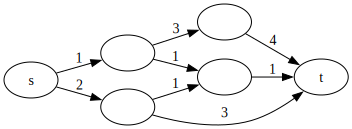

In [2]:
graph1 = Digraph()
graph1.attr(rankdir='LR')
graph1.node('S', 's')
graph1.node('A', '')
graph1.node('B', '')
graph1.node('C', '')
graph1.node('D', '')
graph1.node('T', 't')
graph1.edge('S', 'A', '1', color="black")
graph1.edge('S', 'C', '2', color="black")
graph1.edge('A', 'B', '3', color="black")
graph1.edge('A', 'D', '1', color="black")
graph1.edge('C', 'T', '3', color="black")
graph1.edge('C', 'D', '1', color="black")
graph1.edge('B', 'T', '4', color="black")
graph1.edge('D', 'T', '1', color="black")
display(graph1)

We want to route people through this network. Each edge belongs to a particular agent and they earn the cost of that edge for each person that comes through. We want to minimize the cost but don't know the true edge values, and each agent obviously wants to maximize the return they get (hence facing an incentive to lie and make their edge seem better than it is). Is there any way to fix this?

## 10.2 Mechanism Design with unrestricted preferences

A useful place to start is to return to the idea of a Bayesian game. Bayesian games can be represented in a few ways (see chapter 6), the most useful here being the 'Epistemic type' way. Agents have some 'type', which is unknown to us, representing their individual preferences, and utility depends on both the type and actions of each player. When it comes to Mechanism Design we are providing both the actions and utility functions, under some restrictions, and trying to get some behaviour from the agents optimal to us. For instance, we might want our agents to choose the best combined option, rather than the best just for themselves. Key to Mechanism Design is the restriction on what we can do. In the book they introduce the idea of existing 'outcomes' which have utilities for the players, and all we can do is change the actions and the probabilities of outcomes under those actions. This ends up being a restriction on our ability to change the utilities. Say I have two outcomes, $O_1$ and $O_2$, which will have an unknown utility to the players of ($a_1,b_1$) and ($a_2,b_2$). If we allow both player to take a single binary choice ($C$ or $D$) then we just need to define a function which maps each choice to the probability of the outcomes (here let $p_{CC}$ mean the probability of outcome 1 given actions $CC$) and we end up with this table:

$
\begin{array}{c|cc}
\text{} & \text{C} & \text{D} \\
\hline
\text{C} & p_{CC}a_1+(1-p_{CC})a_2,p_{CC}b_1+(1-p_{CC})b_2 & p_{CD}a_1+(1-p_{CD})a_2,p_{CD}b_1+(1-p_{CD})b_2 \\
\text{D} & p_{DC}a_1+(1-p_{DC})a_2,p_{DC}b_1+(1-p_{DC})b_2 & p_{DD}a_1+(1-p_{DD})a_2,p_{DD}b_1+(1-p_{DD})b_2 \\
\end{array}
$

Say we want it so that if both players prefer option $O_1$ we want them to always get it. How can we go about doing that? One way is to set the probabilities above so that if both players go $C$ they get $O_1$ and otherwise they get $O_2$. I.e., $p_{CC}=1$, all others are 0. This gives us the table:

$
\begin{array}{c|cc}
\text{} & \text{C} & \text{D} \\
\hline
\text{C} & a_1,b_1 & a_2,b_2 \\
\text{D} & a_2,b_2 & a_2,b_2 \\
\end{array}
$

If both players prefer option 1 they will choose $C$. This is the heart of mechanism design. Of course, saying something like *if both players prefer A then they get A* is just more social choice bogus. A more sensible way to think about it is that we have our own utility function that depends on the success of the players. 

### 10.2.1 Implementation

A mechanism is a dominant implementation if it means that agents wouldn't ever deviate from their strategy, given any utility function. The book mentions stuff about matching a social choice function (UGH). A further weaker notion is that no agent would deviate given the strategy of the other agent (i.e., at Nash equilibrium). 

In the example above we have a dominant implementation. If I am the row player and I prefer $O_1$ to $O_2$ then I will always go $C$, otherwise $D$. Given my preferences the strategy won't change, and aligns with the aims of the designer. 

### 10.2.2 The revelation principle

One thing we might want is that agents truthfully reveal their type / preferences. It turns out that there is *always* a mechanism to do this *if* you have an existing mechanism with a dominant strategy implementation. The basic idea is quite simple. The new mechanism will only allow the agents to simply state their utilities. It will then plug those utilities into the first mechanism. Consider the example before:

$
\begin{array}{c|cc}
\text{} & \text{C} & \text{D} \\
\hline
\text{C} & a_1,b_1 & a_2,b_2 \\
\text{D} & a_2,b_2 & a_2,b_2 \\
\end{array}
$

Now instead of choosing $C$ or $D$ we just let agents tell us $a_1$ and $a_2$ etc. We then plug those into the original mechanism to figure out what to do. Because the original mechanism is designed such that agents have dominant strategies there is no reason to lie about your utilities. Lying would imply that you might prefer to play $s^\prime$ instead of $s$, which can't be true. Essentially the original mechanism is designed to do the best thing it can with the information you provide it, so therefore you should provide it correct information.

This is very useful because if any successful mechanism can be implemented as a *truthful mechanism*, where the agents can only state preferences, then we have a much smaller space to search. Essentially the choice about what actions to allow the players goes away. We can just search the space of mechanisms which just allow the players to state their preferences, trying to find one where the optimal strategy is to be truthful and that means our 'optimal' outcome requirements. 

**We just need to search the space of mechanisms where truth-telling is optimal.**

### 10.2.3 Impossibility of general, dominant-strategy implementation

